In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib agg


import global_settings
from utils import settings, experiments, results
import jax
from multiprocessing import Pool
from tqdm import tqdm
import jax.numpy as jnp
import os
import visualization
import transformations
import flax.linen as nn
from data import datasets
import inference
import optax
import models
rng_key = jax.random.PRNGKey(0)

# point estimates

# from here: MCMC based

In [2]:
samples_per_chain = 1024

experiment = experiments.ExperimentSampleStandard(
    settings=settings.SettingsExperimentSample(
        output_path=global_settings.PATH_FIGURES,
        dataset="sinusoidal",
        dataset_normalization="standardization",
        hidden_layers=2,
        hidden_neurons=16,
        activation="tanh",
        activation_last_layer="none",
        num_warmup=2**10,
        statistic="reduced",
        statistic_p=0.95,
        samples_per_chain=samples_per_chain,
        identifiable_modes=1,
        pool_size=8,
        seed=0
    )
)

normalized probabilities: [1.]


In [3]:
experiment.run()
result = experiment.result()

model transformation parameters 321
number of chains: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [15:26<00:00, 46.31s/it]


In [4]:
parameters = result.samples["parameters"]
print(parameters.shape)
n, d = parameters.shape
parameters = parameters.reshape((samples_per_chain, -1, d))
print(parameters.shape)

(20480, 321)
(1024, 20, 321)


In [15]:
point_estimates_intra_chain = jnp.array([
    parameters[0, 0],
    parameters[0, 1],
    parameters[0, 5],
    parameters[0, 3]
])

point_estimates_inter_chain = jnp.array([
    parameters[0, 0],
    parameters[1, 0],
    parameters[2, 0],
    parameters[3, 0]
])

In [16]:
model = experiment._model
std = result.samples["std"].mean()

def log_posterior_simplified(parameters):
    return model.log_posterior_parameters(parameters, std=std)

# same chain

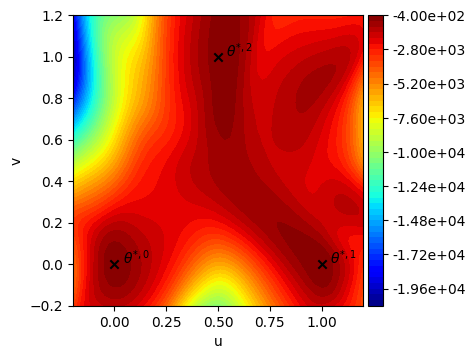

In [52]:
figure = visualization.CutFigure()
figure.plot(log_density=log_posterior_simplified, basis=point_estimates_intra_chain[:-1], resolution=64)

In [53]:
figure._figure.savefig(os.path.join(global_settings.PATH_FIGURES, "same_chain_01.png"), bbox_inches="tight", dpi=96)

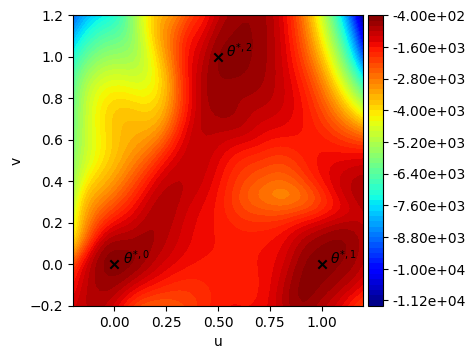

In [54]:
figure = visualization.CutFigure()
figure.plot(log_density=log_posterior_simplified, basis=point_estimates_intra_chain[1:], resolution=64)

In [55]:
figure._figure.savefig(os.path.join(global_settings.PATH_FIGURES, "same_chain_02.png"), bbox_inches="tight", dpi=96)

# different chains

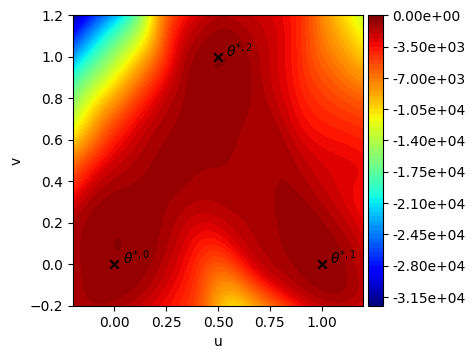

In [56]:
figure = visualization.CutFigure()
figure.plot(log_density=log_posterior_simplified, basis=point_estimates_inter_chain[:-1], resolution=64)

In [57]:
figure._figure.savefig(os.path.join(global_settings.PATH_FIGURES, "different_chains_01.png"), bbox_inches="tight", dpi=96)

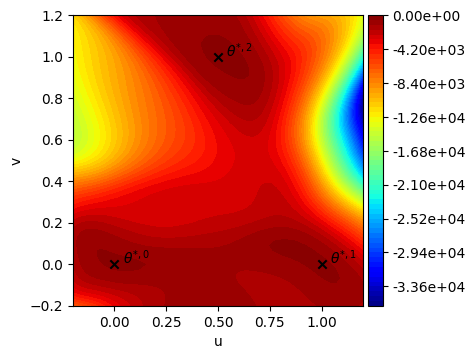

In [58]:
figure = visualization.CutFigure()
figure.plot(log_density=log_posterior_simplified, basis=point_estimates_inter_chain[1:], resolution=64)

In [59]:
figure._figure.savefig(os.path.join(global_settings.PATH_FIGURES, "different_chains_02.png"), bbox_inches="tight", dpi=96)